In [1]:
import tensorflow as tf
import os
import cv2
import math
import json
import numpy as np
from matplotlib import pyplot as plt
from keras.applications import EfficientNetB7
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [3]:
base_dir = "Styles"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

img_size = (224, 224)
batch_size = 16

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int",
    interpolation="bilinear"
)

val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int",
    interpolation="bilinear"
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int",
    interpolation="bilinear"
)

Found 5350 files belonging to 7 classes.
Found 1397 files belonging to 7 classes.
Found 802 files belonging to 7 classes.


In [4]:
class_names = train_data.class_names
print("Class names test:", class_names)

with open("CarStyle map.json", "w") as f:
    json.dump(class_names, f)

data_iterator = train_data.as_numpy_iterator()

Class names test: ['Convertible', 'Coupe', 'Hatchback', 'Pick-Up', 'SUV', 'Sedan', 'VAN']


In [5]:
batch = data_iterator.next()
num_classes = len(class_names)

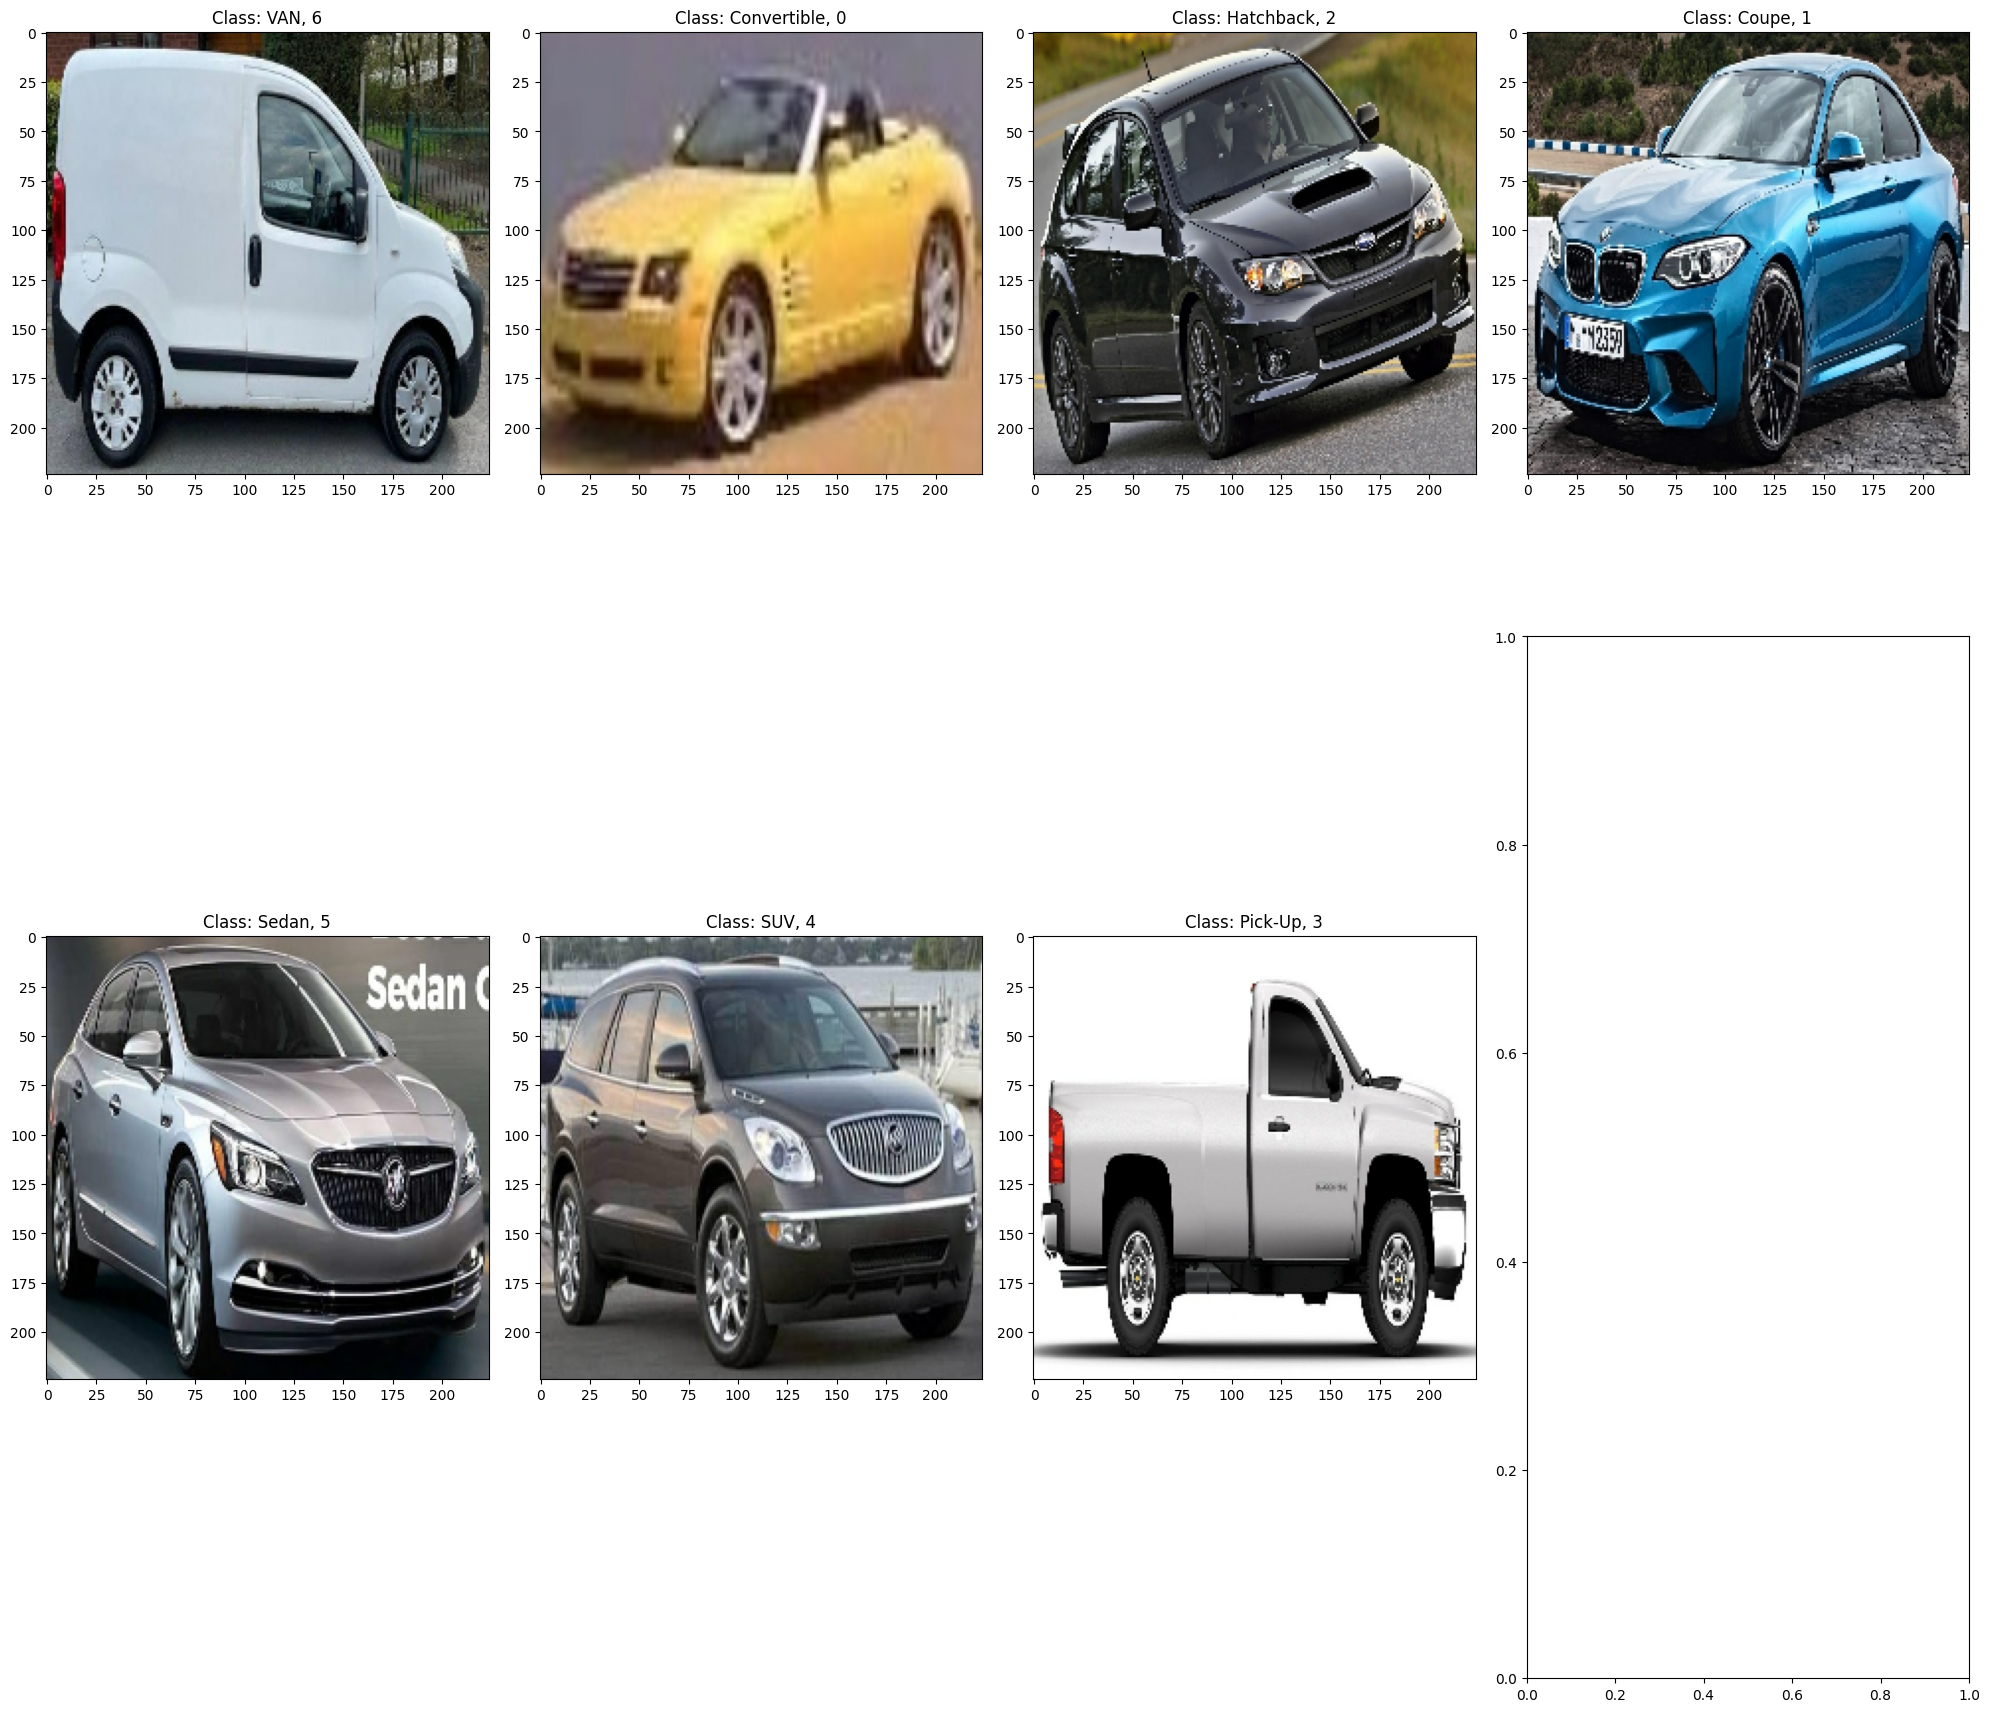

In [6]:
ncols = 4
nrows = math.ceil(num_classes / ncols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

if nrows == 1:
    ax = ax.flatten()
elif ncols == 1:
    ax = ax.flatten()

plotted = set()
count = 0
while count < num_classes:
    batch = next(data_iterator)

    for idx, img in enumerate(batch[0]):
        label = batch[1][idx]
        if label not in plotted:
            ax_idx = count if nrows == 1 or ncols == 1 else (count // ncols, count % ncols)
            ax[ax_idx].imshow(img.astype(int))
            ax[ax_idx].title.set_text(f"Class: {class_names[label]}, {label}")
            plotted.add(label)
            count += 1

        if count == num_classes:
            break

plt.tight_layout()
plt.show()

In [7]:
base_model = EfficientNetB7(
    weights="imagenet",                    
    include_top=False,         
    input_shape=(224, 224, 3) 
)
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

hist = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20
335/335 [==============================] - 96s 234ms/step - loss: 0.6225 - accuracy: 0.7817 - val_loss: 0.4967 - val_accuracy: 0.8790
Epoch 2/20
335/335 [==============================] - 76s 226ms/step - loss: 0.2577 - accuracy: 0.9140 - val_loss: 0.3164 - val_accuracy: 0.9026
Epoch 3/20
335/335 [==============================] - 76s 226ms/step - loss: 0.1854 - accuracy: 0.9372 - val_loss: 0.2961 - val_accuracy: 0.9134
Epoch 4/20
335/335 [==============================] - 78s 231ms/step - loss: 0.1589 - accuracy: 0.9473 - val_loss: 0.2870 - val_accuracy: 0.9198
Epoch 5/20
335/335 [==============================] - 77s 230ms/step - loss: 0.1156 - accuracy: 0.9643 - val_loss: 0.3956 - val_accuracy: 0.9112
Epoch 6/20
335/335 [==============================] - 76s 226ms/step - loss: 0.1114 - accuracy: 0.9654 - val_loss: 0.1676 - val_accuracy: 0.9485
Epoch 7/20
335/335 [==============================] - 76s 226ms/step - loss: 0.0896 - accuracy: 0.9723 - val_loss: 0.2420 - val_ac

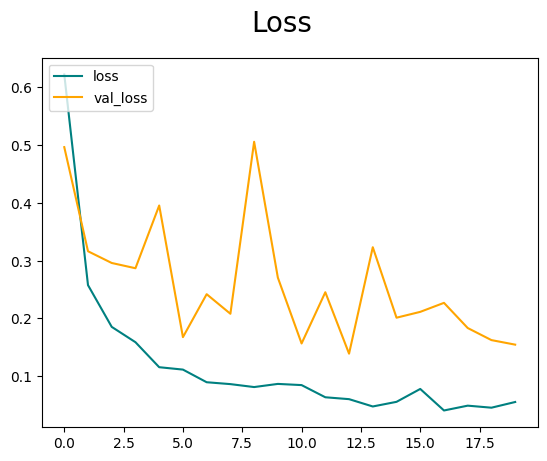

In [9]:
fig = plt.figure()
plt .plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

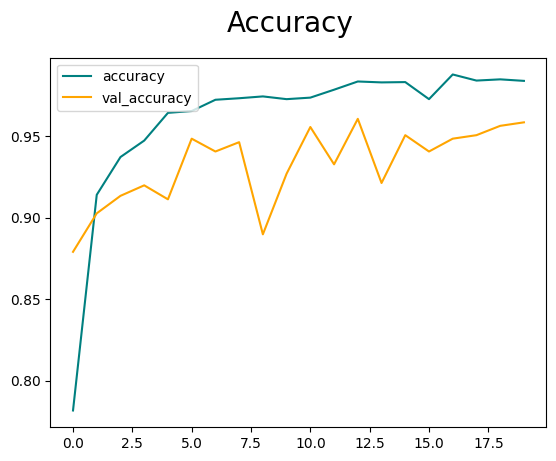

In [10]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="teal", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [11]:
pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()

In [12]:
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    
    yhat_classes = tf.argmax(yhat, axis=1)
    
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 30ms/step


In [13]:
print(f"Precision: {pre.result().numpy() * 100 : .2f}%")
print(f"Recall: {re.result().numpy() * 100 : .2f}%")
print(f"Accuracy: {acc.result().numpy() * 100 : .2f}%")

Precision:  99.52%
Recall:  99.36%
Accuracy:  95.26%


1/1 [==============================] - 2s 2s/step


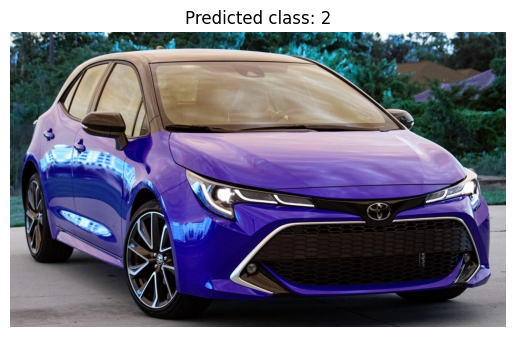

In [14]:
img = cv2.imread("Styles/test/Hatchback/8_jpg.rf.c314c1d6777942876503fa1482c82240.jpg")

img_resized = cv2.resize(img, img_size)
img_expanded = np.expand_dims(img_resized, axis=0)

yhat = model.predict(img_expanded)
predicted_class = tf.argmax(yhat, axis=1).numpy()[0]

plt.imshow(img) 
plt.title(f"Predicted class: {predicted_class}")
plt.axis("off") 
plt.show()

In [15]:
print(f"Predicted class is: {class_names[predicted_class]}")
for idx, prob in enumerate(yhat[0]):
    print(f"Model probability for {class_names[idx]} is {prob * 100:.2f}%")

Predicted class is: Hatchback
Model probability for Convertible is 0.00%
Model probability for Coupe is 0.00%
Model probability for Hatchback is 100.00%
Model probability for Pick-Up is 0.00%
Model probability for SUV is 0.00%
Model probability for Sedan is 0.00%
Model probability for VAN is 0.00%


In [16]:
model_file_name = f"CarStyle{acc.result().numpy() * 100 : .2f}% EfficientNetB7.h5"
model.save(os.path.join("CarBackEnd/models/CarStyles", model_file_name))

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.